**Title**: Financial Stock Analysis and Clustering

---


**Version**: 5.0

---


**Authors**: Raza Mehar

---


**Course**: Hawardware and Software for Big Data

---


**Initiation date**: 15th Dec, 2023

In [1]:
# Load the relevant libraries
!pip install kafka-python
!pip install yfinance --upgrade --no-cache-dir
!pip install pyspark
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!make install
!pip install TA-Lib
%cd /content

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.5/246.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=9060c70fc8eadfd25a078b3d6acb1b50d673c8e055f682235d7fbc839a823364
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark
--2024-01-26 08:09:05--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2024-01-26 08:09:05--  http://downloads.sourcefo

In [2]:
# Import all the relvant libraries and modules
import time
from kafka import KafkaProducer
import pandas as pd
import numpy as np
import yfinance as yf
from pyspark.sql import SparkSession
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
import talib
import json

/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()


In [3]:
# Download and extract the Kafka distribution archive using curl and tar respectively
!curl -sSOL https://archive.apache.org/dist/kafka/3.3.1/kafka_2.13-3.3.1.tgz
!tar -xzf kafka_2.13-3.3.1.tgz

In [4]:
# Start Apache Zookeeper and Apache Kafka, and then waiting for 10 seconds to ensure that the services have enough time to initialize before moving on to other tasks
!./kafka_2.13-3.3.1/bin/zookeeper-server-start.sh -daemon ./kafka_2.13-3.3.1/config/zookeeper.properties
!./kafka_2.13-3.3.1/bin/kafka-server-start.sh -daemon ./kafka_2.13-3.3.1/config/server.properties
!echo "Waiting for 10 secs until kafka and zookeeper services are up and running"
!sleep 10

Waiting for 10 secs until kafka and zookeeper services are up and running


In [5]:
# Create a Kafka topic which will be used later with Kafka producer to store the processed data
!./kafka_2.13-3.3.1/bin/kafka-topics.sh --create --bootstrap-server 127.0.0.1:9092 --replication-factor 1 --partitions 1 --topic BigDataProject

Created topic BigDataProject.


**Data Crawling**

In [6]:
# Create a list of stock symbols of all the 157 US companies in the energy sector
tickers = ["AMR", "ARCH", "AREC", "ARLP", "BTU", "CEIX", "HCC", "HNRG", "METC", "METCB", "METCL", "NC", "NRP", "MGEE", "LFUS", "POWL",
"SLDP", "SLDPW", "BE", "EAF", "FCEL", "PLUG", "THR", "WWD", "BPT", "CLMT", "COP", "CVI", "CVX", "DK", "HES", "MPC",
"PARR", "PBF", "PSX", "SUN", "VLO", "VTNR", "XOM", "DINO", "DKL", "MPLX", "NS", "NSS", "PAA", "PAGP", "AMPY", "APA",
"AR", "AROC", "BATL", "BRN", "BRY", "BSM", "CEI", "CHK", "CHKEL", "CHKEW", "CHRD", "CIVI", "CKX", "CNX", "CPE",
"CRC", "CRGY", "CRK", "CRT", "CTRA", "DMLP", "DO", "DVN", "DWSN", "EGY", "EOG", "EP", "EPM", "EPSN", "EQT", "FANG",
"GBR", "GPOR", "HESM", "HP", "HPK", "HPKEW", "HUSA",  "KRP", "MARPS", "MGY", "MRO", "MTDR", "MTR", "MUR", "MVO", "MXC",
"NFG", "NOG", "NRT", "OXY", "PBT", "PED", "PHX", "PNRG", "PR", "PRT", "PTEN", "PVL", "PXD", "REI", "REPX",
"ROI", "RRC", "SBOW", "SBR", "SD", "SJT", "SM", "STR", "SWN", "TALO", "TELL", "TELZ", "TPL", "TTI", "USEG",
"VAL", "VNOM", "VOC", "VTLE", "VTS", "WTI", "ACDC", "CCLP", "ENSV", "HAL", "HLX", "KLXE", "LBRT", "NCSM", "NGS", "NINE",
"OII", "PUMP","RES", "RNGR", "TUSK", "VIVK", "WTTR", "XPRO", "AE", "ARKO", "ARKOW", "CAPL", "GEL", "GLP", "MMLP", "WKC"]

start_date = "2023-01-01"
end_date = "2023-12-31"

print("Extracting data of all the 157 US comapanies operating in the energy sector from Yahoo! Finance.\n")
data = yf.download(tickers, start = start_date, end = end_date, interval = '1mo')
print("\nData has been successfully retrieved.")

Extracting data of all the 157 US comapanies operating in the energy sector from Yahoo! Finance.



[*********************100%%**********************]  157 of 157 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['SLDPW', 'ARKOW']: Exception("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")



Data has been successfully retrieved.


**Data Review**

In [7]:
# Review the dataset by showcasing the initial and final rows, data types, and dimensions
print("Type of the dataset:", type(data))
print("\n")
print("The data types of the feature in dataframe:\n", data.dtypes)
print("\n")
print("Shape of the dataframe:", data.shape)
print("\n")
print("Columns in the dataframe:", data.columns)
print("\n")
print("\nHead of the dataframe:\n",data.head())
print("\nTail of the dataframe:\n",data.tail())

Type of the dataset: <class 'pandas.core.frame.DataFrame'>


The data types of the feature in dataframe:
 Price      Ticker
Adj Close  ACDC      float64
           AE        float64
           AMPY      float64
           AMR       float64
           APA       float64
                      ...   
Volume     WTI         int64
           WTTR        int64
           WWD         int64
           XOM         int64
           XPRO        int64
Length: 942, dtype: object


Shape of the dataframe: (12, 942)


Columns in the dataframe: MultiIndex([('Adj Close',  'ACDC'),
            ('Adj Close',    'AE'),
            ('Adj Close',  'AMPY'),
            ('Adj Close',   'AMR'),
            ('Adj Close',   'APA'),
            ('Adj Close',    'AR'),
            ('Adj Close',  'ARCH'),
            ('Adj Close',  'AREC'),
            ('Adj Close',  'ARKO'),
            ('Adj Close', 'ARKOW'),
            ...
            (   'Volume',   'VOC'),
            (   'Volume',  'VTLE'),
            (   'V

**Data Pre-processing**

In [8]:
# Flatten the dataframe from MultiIndex as the features for all the stocks symbols are homogenous.
data1 = data.stack(level=1).reset_index()

data1.columns = ["Date", "Stock", "Adj Close", "Close", "High", "Low", "Open", "Volume"]
# Drop less relevant features from the dataframe
data1.drop(["Open", "Close", "Volume"], axis = 1, inplace = True)

# Review the flattened dataframe by showcasing the initial and final rows, data types, and dimensions
print("Type of the dataset:", type(data1))
print("Shape of the dataframe:", data1.shape)
print("Columns in the dataframe:", data1.columns)
print("\nHead of the dataframe:\n", data1.head())
print("\nTail of the dataframe:\n", data1.tail())

Type of the dataset: <class 'pandas.core.frame.DataFrame'>
Shape of the dataframe: (1853, 5)
Columns in the dataframe: Index(['Date', 'Stock', 'Adj Close', 'High', 'Low'], dtype='object')

Head of the dataframe:
         Date Stock   Adj Close        High         Low
0 2023-01-01  ACDC   22.500000   25.440001   19.832001
1 2023-01-01    AE   46.759800   51.500000   37.500000
2 2023-01-01  AMPY    8.660000    9.360000    7.700000
3 2023-01-01   AMR  159.314117  174.554993  130.539993
4 2023-01-01   APA   42.908794   46.980000   41.360001

Tail of the dataframe:
            Date Stock   Adj Close        High         Low
1848 2023-12-01   WTI    3.260000    3.440000    2.860000
1849 2023-12-01  WTTR    7.590000    7.818000    7.065000
1850 2023-12-01   WWD  136.130005  140.729996  132.440002
1851 2023-12-01   XOM   99.980003  104.220001   97.480003
1852 2023-12-01  XPRO   15.920000   17.000000   14.440000


In [9]:
# Check for duplicate and missing values in the dataframe
print("Are there any dupliacates in the dataframe?", data1.duplicated().any())
print("Count of missing values in the dataframe:\n", data1.isna().sum())

Are there any dupliacates in the dataframe? False
Count of missing values in the dataframe:
 Date         0
Stock        0
Adj Close    0
High         0
Low          0
dtype: int64


**Descriptive Statistics**

In [10]:
# Display descriptive statistics of 10 random stocks
stock_names = ["BATL", "CTRA", "EQT", "GLP", "GPOR", "HAL", "HCC", "HES", "HESM", "HLX"]
data_des = data1.groupby('Stock')["Adj Close"].describe()
print("Descriptive statistics of 'Adj Close' for 10 random stocks:\n", data_des[data_des.index.isin(stock_names)])

Descriptive statistics of 'Adj Close' for 10 random stocks:
        count        mean        std         min         25%         50%  \
Stock                                                                     
BATL    12.0    7.149167   1.734738    5.030000    5.947500    6.375000   
CTRA    12.0   25.379454   1.671601   22.732538   23.898141   25.275118   
EQT     12.0   37.650856   4.309003   31.531101   33.925738   39.235739   
GLP     12.0   32.150117   4.072017   27.100784   29.359169   31.299057   
GPOR    12.0  103.314999  23.866740   66.120003   87.844999  103.759998   
HAL     12.0   35.802979   3.920998   28.263308   32.485541   36.428856   
HCC     12.0   43.017597   9.122018   32.605793   36.666106   39.127926   
HES     12.0  141.716834   9.040413  125.542862  134.321373  143.743988   
HESM    12.0   28.637933   1.967842   25.345642   27.536236   28.536904   
HLX     12.0    8.764167   1.489908    6.280000    7.650000    8.800000   

              75%         max  
Stock 

**Visualization for Data Distribution**

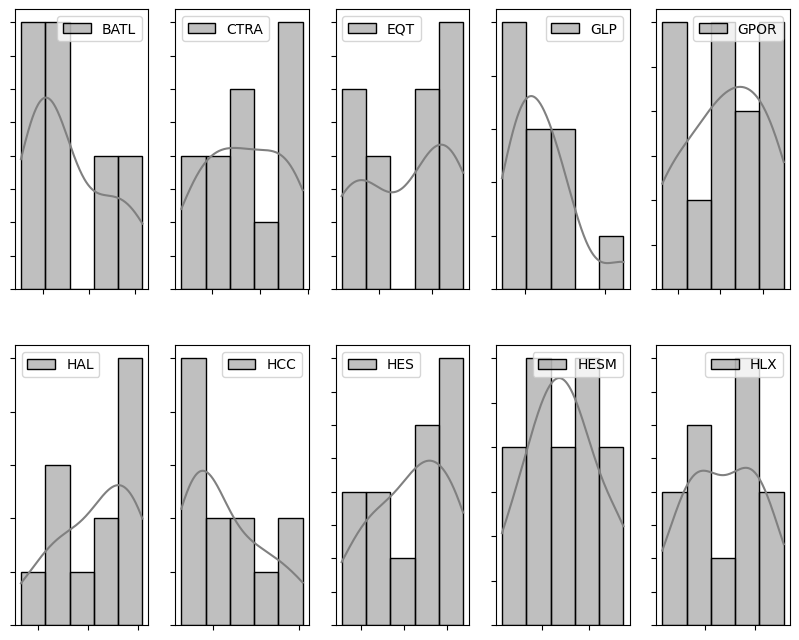

In [11]:
fig, axes = plt.subplots(2, 5, figsize = (10, 8))

for ax, stock_name in zip(axes.flat, stock_names):
  sns.histplot(data = data1[data1["Stock"] == stock_name], x = "Adj Close", kde = True, ax = ax, label = stock_name, color = "grey")
  ax.set_xticklabels("")
  ax.set_yticklabels("")
  ax.set_xlabel("")
  ax.set_ylabel("")
  ax.legend()

**Top 10 and bottom 10 stocks based on the mean of the adjusted closing price**

In [12]:
# Display information of top 10 stocks based on the mean of the adjusted closing price
data_ds = data1.groupby("Stock")["Adj Close"].mean().sort_values(ascending = False)
print("Top 10 stocks based on the mean of the adjusted closing price:\n", data_ds.head(10), "\n")
print("TPL seems like an outlier.\n")
print("Bottom 10 stocks based on the mean of the adjusted closing price:\n", data_ds.tail(10), "\n")

Top 10 stocks based on the mean of the adjusted closing price:
 Stock
TPL     1649.163116
LFUS     257.661724
PXD      213.949964
AMR      199.517476
CVX      155.440557
CHRD     146.821609
HES      141.716834
FANG     141.164201
ARCH     135.544310
MPC      132.315926
Name: Adj Close, dtype: float64 

TPL seems like an outlier.

Bottom 10 stocks based on the mean of the adjusted closing price:
 Stock
DWSN    1.817500
AREC    1.558333
USEG    1.522408
CCLP    1.312837
TELL    1.234167
GBR     1.113333
VIVK    1.080283
PED     0.930250
CEI     0.890833
ENSV    0.460833
Name: Adj Close, dtype: float64 



**Time-Series Visualizations for Top and Bottom 10 Stocks**

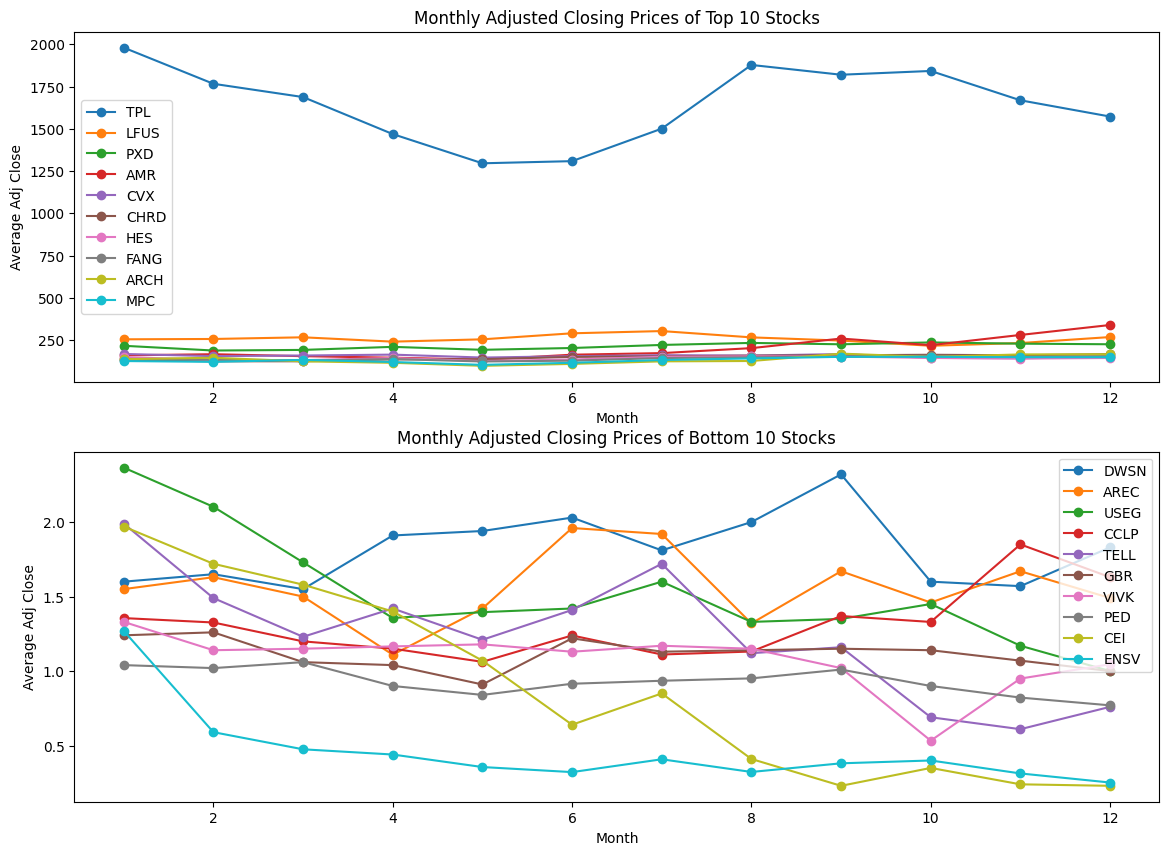

In [13]:
# Display time-series visualizations for top 10 and bottom 10 stocks over the months based on adj closing prices
top_stocks = list(data_ds.head(10).index)
bottom_stocks = list(data_ds.tail(10).index)

## Create a month feature based on the dates in the data
data1["Month"] = data1["Date"].dt.month

## Group the data based on Stock
data_ds = data1.groupby("Stock")

fig, ax = plt.subplots(2, 1, figsize = (14, 10))
for stock in top_stocks:
    ### Extract stock name from the list of top stock
    stock_data = data_ds.get_group(stock)
    ax[0].plot(stock_data["Month"], stock_data["Adj Close"], label=f'{stock}', marker='o')
    #ax[0].title("Monthly Adjusted Closing Prices of Top 10 Stocks")
ax[0].set_title("Monthly Adjusted Closing Prices of Top 10 Stocks")
for stock in bottom_stocks:
    ### Extract stock name from the list of bottom stocks and pick values from the Adj Close column
    stock_data = data_ds.get_group(stock)
    ax[1].plot(stock_data["Month"], stock_data["Adj Close"], label=f'{stock}', marker='o')
    #ax[1].title("Monthly Adjusted Closing Prices of Bottom 10 Stocks")
ax[1].set_title("Monthly Adjusted Closing Prices of Bottom 10 Stocks")
ax[0].set_ylabel('Average Adj Close')
ax[1].set_ylabel('Average Adj Close')
ax[0].legend()
ax[1].legend()
ax[0].set_xlabel('Month')
ax[1].set_xlabel('Month')
plt.show()

**Feature Engineering**

In [14]:
'''Apply technical analysis to feature engineer Simple Moving Average, Exponential Moving Average, Relative Strength Index, Returns, Volatility, and Average True Range of the stocks
with a time period of 3 months ensuring quaterly division of stocks data.'''
data_TA = data1.groupby("Stock")
result_df = []

for stock, stock_data in data_TA:
    stock_data = stock_data.sort_values(by = "Month")

    ### Calculate simple moving average that gives equal weight to all data points
    stock_data["SMA"] = talib.SMA(stock_data["Adj Close"], timeperiod = 3)

    ### Calculate exponential moving average that gives more weight to recent data points
    stock_data["EMA"] = talib.EMA(stock_data["Adj Close"], timeperiod = 3)

    ### Calculate relative strength index (RSI) to identify if a stock is overbought or oversold
    stock_data['RSI'] = talib.RSI(stock_data["Adj Close"], timeperiod = 3)

    ### Calculate daily returns that tells % change in the worth of the stock
    stock_data["Returns"] = stock_data["Adj Close"].pct_change()

    ### Calculate volatility of the stocks that describes the fluctuation in price of the stock using standard deviation
    stock_data["Volatility"] =talib.STDDEV(stock_data["Adj Close"], timeperiod = 3)

    ### Calculate volatility of the stocks that describes the fluctuation in price of the stock using Average True Range
    stock_data["ATR"] = talib.ATR(stock_data["High"], stock_data["Low"], stock_data["Adj Close"], timeperiod=3)

    ### Storing the results in a list to be used later when performing RDD filter operations and clustering
    result_df.append(stock_data)
    #print(f"\nStock: {stock}")
    #print(stock_data.tail())
## Conver the list to pandas dataframe
result_df = pd.concat(result_df, ignore_index=True)
result_df

,Date,Stock,Adj Close,High,Low,Month,SMA,EMA,RSI,Returns,Volatility,ATR
0,2023-01-01,ACDC,22.500000,25.440001,19.832001,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-02-01,ACDC,19.129999,22.530001,18.559999,2,NaN,NaN,NaN,-0.149778,NaN,NaN
2,2023-03-01,ACDC,12.670000,21.780001,10.150000,3,18.100000,18.100000,NaN,-0.337689,4.078635,NaN
3,2023-04-01,ACDC,11.200000,13.960000,10.550000,4,14.333333,14.650000,0.000000,-0.116022,3.444438,6.336667
4,2023-05-01,ACDC,11.220000,12.505000,9.010000,5,11.696667,12.935000,0.264790,0.001786,0.688299,5.389445
...,...,...,...,...,...,...,...,...,...,...,...,...
1848,2023-08-01,XPRO,23.510000,24.500000,21.450001,8,21.140000,21.800729,76.103334,0.059486,2.477620,4.321769
1849,2023-09-01,XPRO,23.230000,25.040001,22.320000,9,22.976667,22.515364,72.168860,-0.011910,0.567881,3.787846
1850,2023-10-01,XPRO,15.750000,23.290001,15.250000,10,20.830000,19.132682,23.495129,-0.321997,3.593921,5.205231
1851,2023-11-01,XPRO,15.550000,16.389999,14.330000,11,18.176667,17.341341,22.876329,-0.012698,3.574179,4.156821


**Data Pre-processing post Feature Engineering**

In [15]:
# Check for missing values in the dataframe as new features have been added
print("Count of missing values in the dataframe:\n", result_df.isna().sum())
#Impute missing values in SMA, EMA, RSI, Returns and Volatility
result_df.fillna(result_df.mean(), inplace=True)
print("\nCount of missing values in the dataframe:\n", result_df.isna().sum())

Count of missing values in the dataframe:
 Date            0
Stock           0
Adj Close       0
High            0
Low             0
Month           0
SMA           310
EMA           310
RSI           465
Returns       155
Volatility    310
ATR           465
dtype: int64

Count of missing values in the dataframe:
 Date          0
Stock         0
Adj Close     0
High          0
Low           0
Month         0
SMA           0
EMA           0
RSI           0
Returns       0
Volatility    0
ATR           0
dtype: int64


<ipython-input-15-d9b9ad5cecb2>:4: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  result_df.fillna(result_df.mean(), inplace=True)
<ipython-input-15-d9b9ad5cecb2>:4: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  result_df.fillna(result_df.mean(), inplace=True)


In [16]:
# Create a PySpark session and convert the DataFrame into an RDD to enable distributed processing and ensure fault tolerance in case of node failures
spark = SparkSession.builder.appName("Raza_Final_Project_Big_Data_A").getOrCreate()
result_df_spark = spark.createDataFrame(result_df)
result_df_RDD = result_df_spark.rdd
print("Initiating a PySpark session\n")
time.sleep(0.5)
print("Converting the data frame into RDD.\n")
for i in range(0, 101, 5):
  print("**", end = "")
  time.sleep(0.1)
print("\nRDD has been successfully created.\n")

def get_unique_symbols(rdd):
    return set(row[1] for row in rdd.collect())

Initiating a PySpark session

Converting the data frame into RDD.

******************************************
RDD has been successfully created.



**Stock Evaluation**

In [17]:
# Extract overbought and oversold stocks based on RSI and underpriced stocks based on SMA, EMA and RSI in December
overbought_stocks_rdd = result_df_RDD.filter(lambda x: x[8] > 70 and x[5] == 12)
oversold_stocks_rsi_rdd = result_df_RDD.filter(lambda x: x[8] <30 and x[5] == 12)

bullish_stocks_sma_rdd = result_df_RDD.filter(lambda x: x[4] > x[6] and x[5] == 12)
bullish_stocks_ema_rdd = result_df_RDD.filter(lambda x: x[4] > x[7] and x[5] == 12)

bearish_stocks_sma_rdd = result_df_RDD.filter(lambda x: x[4] < x[6] and x[5] == 12)
bearish_stocks_ema_rdd = result_df_RDD.filter(lambda x: x[4] < x[7] and x[5] == 12)

bullish_stocks_sma_symbols = get_unique_symbols(bullish_stocks_sma_rdd)
bullish_stocks_ema_symbols = get_unique_symbols(bullish_stocks_ema_rdd)
bearish_stocks_sma_symbols = get_unique_symbols(bearish_stocks_sma_rdd)
bearish_stocks_ema_symbols = get_unique_symbols(bearish_stocks_ema_rdd)
overbought_symbols = get_unique_symbols(overbought_stocks_rdd)
oversold_rsi_symbols = get_unique_symbols(oversold_stocks_rsi_rdd)

print("The strong stocks based on the comparison of adjusted closing price with SMA:", bullish_stocks_sma_symbols)
print("\nThe strong stocks based on the comparison of adjusted closing price with EMA:", bullish_stocks_ema_symbols)
print("\nThe weak stocks based on the comparison of adjusted closing price with SMA:", bearish_stocks_sma_symbols)
print("\nThe weak stocks based on the comparison of adjusted closing price with EMA:", bearish_stocks_ema_symbols)
print("\nThe overbought stock(s) based on RSI:", overbought_symbols)
print("\nThe oversold stock(s) based on RSI:", oversold_rsi_symbols)



The strong stocks based on the comparison of adjusted closing price with SMA: {'AMR', 'MVO', 'CLMT', 'WWD', 'SBR', 'AROC', 'THR', 'NSS', 'METCL'}

The strong stocks based on the comparison of adjusted closing price with EMA: {'NSS', 'METCL'}

The weak stocks based on the comparison of adjusted closing price with SMA: {'MGY', 'XOM', 'PR', 'CHRD', 'PARR', 'SD', 'TALO', 'MRO', 'CRC', 'OXY', 'MARPS', 'SBOW', 'EQT', 'EGY', 'FANG', 'HLX', 'CPE', 'CTRA', 'BRN', 'NINE', 'PBF', 'FCEL', 'METC', 'KRP', 'PTEN', 'DO', 'CRK', 'MXC', 'MGEE', 'DMLP', 'DK', 'DKL', 'PLUG', 'MPLX', 'SM', 'PAA', 'PUMP', 'ROI', 'GPOR', 'HCC', 'VTNR', 'BRY', 'DVN', 'PED', 'SLDP', 'ENSV', 'MTR', 'EPM', 'RRC', 'EOG', 'VIVK', 'CHKEW', 'PBT', 'PNRG', 'HUSA', 'ARKO', 'VNOM', 'XPRO', 'HES', 'WTTR', 'CRT', 'MMLP', 'NRP', 'BE', 'CEIX', 'PSX', 'ARLP', 'MUR', 'CHK', 'CRGY', 'NS', 'DINO', 'VLO', 'WKC', 'GEL', 'USEG', 'HPKEW', 'AE', 'EP', 'CIVI', 'HP', 'HNRG', 'KLXE', 'CKX', 'BATL', 'SUN', 'RES', 'GLP', 'TTI', 'LFUS', 'WTI', 'TUSK', 'T

**Stock Return Overview**

In [18]:
# Extract lists of stocks that provided returns equal to or greater than 50%, and those that resulted in losses in December
profitable_stocks_RDD = result_df_RDD.filter(lambda x: x[9] >= 0.5 and x[5] == 12)
unprofitable_stocks_RDD = result_df_RDD.filter(lambda x: x[9] < 0.00 and x[5] == 12)

profitable_symbols = get_unique_symbols(profitable_stocks_RDD)
unprofitable_symbols = get_unique_symbols(unprofitable_stocks_RDD)

print("The stocks that gave returns equal or more than 50% are:", profitable_symbols)
print("\nThe stocks that incurred losses are:", unprofitable_symbols)

The stocks that gave returns equal or more than 50% are: {'BATL'}

The stocks that incurred losses are: {'MGY', 'XOM', 'SD', 'MRO', 'SBOW', 'MARPS', 'EQT', 'EGY', 'CTRA', 'BRN', 'PBF', 'PTEN', 'CRK', 'MXC', 'MGEE', 'DK', 'DKL', 'PAA', 'PUMP', 'GPOR', 'PED', 'ENSV', 'MTR', 'EPM', 'RRC', 'EOG', 'CHKEW', 'PBT', 'PNRG', 'CRT', 'MMLP', 'CEIX', 'CHK', 'GEL', 'USEG', 'HPKEW', 'AE', 'CIVI', 'HNRG', 'TTI', 'WTI', 'AMPY', 'APA', 'GBR', 'SJT', 'HAL', 'PRT', 'PXD', 'PVL', 'REI', 'NFG', 'EPSN', 'BSM', 'MTDR', 'CEI', 'BPT', 'PHX', 'TPL', 'EAF', 'NOG', 'METCB', 'HESM', 'VTS', 'NRT', 'VAL', 'AR', 'PAGP', 'SWN', 'VOC', 'CAPL', 'MPC', 'NSS', 'HPK', 'LBRT', 'CCLP', 'CNX', 'CHKEL', 'AREC'}


**Risk Analysis**

In [19]:
# Extract lists of stocks that exhibited extreme volatility in December
max_volatility_STDEV = result_df_RDD.map(lambda x: x[10]).max()
volatile_stocks_STDEV = result_df_RDD.filter(lambda x: x[10] == max_volatility_STDEV)

max_volatility_ATR = result_df_RDD.map(lambda x: x[11]).max()
volatile_stocks_ATR = result_df_RDD.filter(lambda x: x[11] == max_volatility_ATR)

volatile_symbols_STDEV = get_unique_symbols(volatile_stocks_STDEV)
volatile_symbols_ATR = get_unique_symbols(volatile_stocks_ATR)

print("\nThe most volatile stocks using STDEV:", volatile_symbols_STDEV)
print("\nThe most volatile stocks using ATR:", volatile_symbols_ATR)


The most volatile stocks using STDEV: {'TPL'}

The most volatile stocks using ATR: {'TPL'}


**Data Standardization**

In [20]:
# Standardize the dataframe to make the values comparable as there are major differences in the means and standard deviations of the stocks
standardized_df = result_df.groupby("Stock").agg({"Adj Close": "mean", "SMA": "mean", "EMA": "mean", "RSI": "mean", "Returns": "mean", "Volatility": "mean"})
scale = StandardScaler()
standardized_df[["Adj Close", "SMA", "EMA", "RSI", "Returns", "Volatility"]] = scale.fit_transform(standardized_df[["Adj Close", "SMA", "EMA", "RSI", "Returns", "Volatility"]])
standardized_df

,Adj Close,SMA,EMA,RSI,Returns,Volatility
Stock,,,,,,
ACDC,-0.241079,-0.245574,-0.243824,-1.997836,-1.852592,-0.138549
AE,-0.066065,-0.067794,-0.067503,-1.145148,-0.977910,0.018002
AMPY,-0.280122,-0.281784,-0.281718,-1.278367,-0.666824,-0.234483
AMR,1.129943,1.085926,1.101032,1.130275,2.229752,1.769453
APA,-0.057225,-0.056981,-0.056697,-0.497918,-0.206327,-0.041050
...,...,...,...,...,...,...
WTI,-0.299766,-0.301736,-0.301750,-1.543455,-1.245247,-0.240465
WTTR,-0.275956,-0.277512,-0.277308,-0.433891,-0.094560,-0.243800
WWD,0.513184,0.517929,0.518616,1.605842,0.856535,0.178219


In [21]:
def visualize_clusters(cluster_label, ax):

    #   Create a scatter plot based on the clustering algorithm.

    ##  Parameters:
    ### - cluster_label (str): The type of clustering algorithm used ("Cluster_KMeans", "Cluster_HC", "Cluster_SC"). This parameter will also be used to extract clustering values
    ### from the data and assign colors to the data points.
    ### - ax (AxesSubplot): Matplotlib subplot axes.

    ##  Returns:
    ### None

  if cluster_label == "Cluster_KMeans": title = "KMeans Clustering"
  elif cluster_label == "Cluster_HC": title = "Hierarchical Clustering"
  elif cluster_label == "Cluster_SC": title = "Spectral Clustering"

  sns.scatterplot(x = "Returns", y = "Volatility", s = 500, alpha = 0.9, ax = ax, hue= cluster_label, data = standardized_df, palette = "Set1")
  ax.set_title(title)
  ax.set_xlabel("Returns")
  ax.set_ylabel("Volatility")

**Elbow Curve**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

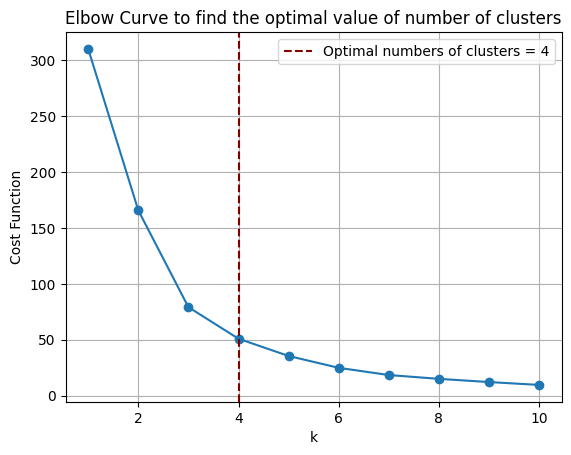

In [22]:
# Display an elbow curve to find the optimal value of number of clusters before applying any clustering algorigthm
n_clusters = range(1, 11)
wcss_values = []
features_for_model = standardized_df[["Returns", "Volatility"]]
for k in n_clusters:

  kmeans = KMeans(n_clusters = k, random_state = 1)
  kmeans.fit(features_for_model)
  wcss_values.append(kmeans.inertia_)

plt.plot(n_clusters, wcss_values, marker = 'o')
plt.xlabel("k")
plt.ylabel("Cost Function")
plt.axvline(4, 0, color="maroon", linestyle="--", label="Optimal numbers of clusters = 4")
plt.grid(True)
plt.title("Elbow Curve to find the optimal value of number of clusters")
plt.legend()
plt.show()

**Data Clustering using K-Means**

In [23]:
# Applying Kmeans clustering based on the optimal value of k = 4
kmeans = KMeans(n_clusters = 4, random_state = 1)
standardized_df["Cluster_KMeans"] = kmeans.fit_predict(features_for_model)
print("Cluster Counts:")
print(standardized_df['Cluster_KMeans'].value_counts())

Cluster Counts:
0    78
3    57
2    19
1     1
Name: Cluster_KMeans, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


**Data Clustering using Hierarchical Clustering**

In [24]:
# Applying Hierarchical Clustering
np.random.seed(1)
#Fitting the model using linkage ward which is an approach to measuring the distance between clusters by minimizing the sum of squares differences
model = AgglomerativeClustering(n_clusters = 4, linkage = "ward")
standardized_df["Cluster_HC"] = model.fit_predict(features_for_model)
print("Cluster Counts:")
print(standardized_df['Cluster_HC'].value_counts())

Cluster Counts:
2    71
1    60
0    23
3     1
Name: Cluster_HC, dtype: int64


**Data Clustering using Spectral Clustering**

In [25]:
spectral = SpectralClustering(n_clusters=4, affinity='nearest_neighbors', random_state=0)
standardized_df["Cluster_SC"] = spectral.fit_predict(features_for_model)
print("Cluster Counts:")
print(standardized_df['Cluster_SC'].value_counts())

Cluster Counts:
0    58
1    47
2    27
3    23
Name: Cluster_SC, dtype: int64


**Clusters Visualization**

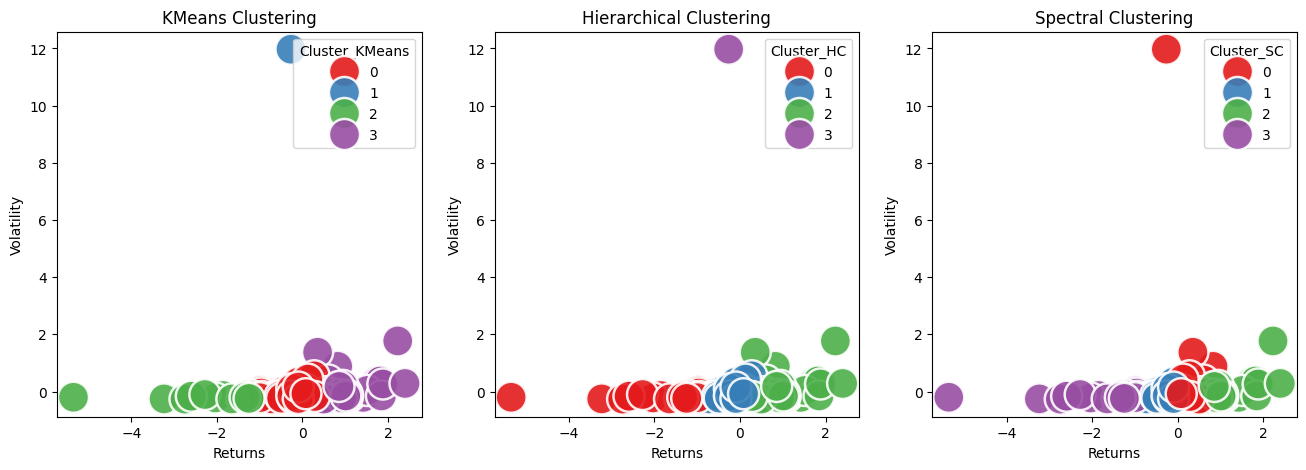

In [26]:
# Visualize the clusters by generating a scatter plot
fig, ax = plt.subplots(1, 3, figsize = (16, 5))

visualize_clusters("Cluster_KMeans", ax[0])
visualize_clusters("Cluster_HC", ax[1])
visualize_clusters("Cluster_SC", ax[2])

plt.show()

**Interpretation of KMeans Clustering**



*   Cluster 0 (red): Stocks in this cluster are unprofitable and likely to continue losing money in the future.
*   Cluster 1 (blue): Represents stocks with high profits and lower volatility, considered stable and reliable.
*   Cluster 2 (green): An outlier containing highly volatile stocks, such as TPL, with potential for medium to higher returns.
*   Cluster 3 (purple): Includes stocks with medium profits and lower volatility, offering a middle ground between riskier and more stable stocks.





**Interpretation of Hierarchical Clustering**



*   Cluster 1 (blue): Stocks are unprofitable and may continue to incur losses.
*   Cluster 0 (red): Comprises stocks with high profits and lower volatility, indicating stability.
*   Cluster 2 (green): Includes stocks with medium profits and lower volatility, providing a balanced option.
*   Cluster 3 (purple): An outlier with TPL, a highly volatile stock offering medium to higher returns.

**Interpretation of Spectral Clustering**

*   Cluster 0 (red): Stocks generate medium to somewhat higher profits with lower volatility.
*   Cluster 1 (blue): Represents stocks with no clear correlation, suggesting a volatile nature.
*   Cluster 2 (green): Comprises unprofitable stocks that have been losing money.
*   Cluster 3 (purple): Stocks with less volatility and high returns, indicating strong correlation among them.

**Summary**

While each algorithm provides unique insights, there is a common theme across clusters suggesting that many energy sector stocks offer a balance of medium to high returns with relatively low volatility. This stability makes them potentially attractive to investors seeking a manageable level of risk in their portfolios.

**Sending data to Kafka**

In [27]:
# Initialize Kafka producer to store processed financial stocks data
producer = KafkaProducer(bootstrap_servers='127.0.0.1:9092', value_serializer=lambda v: json.dumps(v).encode('utf-8'))

data_dict_list = standardized_df.reset_index().to_dict(orient='records')

n = 0
print("Starting to load data onto Kafka.\n")
for data_dict in data_dict_list:
    producer.send('project-data', value=data_dict)
    n += 1
    if n % 5 == 0:
      print("*", end = "")
    time.sleep(0.1)

producer.close()
print("\nProcessed data has been assigned to Kafka topic 'project_data' to be subscribed by other systems.")

Starting to load data onto Kafka.

*******************************
Processed data has been assigned to Kafka topic 'project_data' to be subscribed by other systems.
